# Inverse Probability of Censoring Weights
Your colleague bursts into your office and asks for your help. They are trying to estimate the overall risk of their cohort. They are using Kaplan-Meier but recently read that Kaplan-Meier assumes non-informative censoring (i.e. censoring is unrelated to any causes of the event). They are worried about this assumption and wanted to ask you if there was any way around it or to relax that assumption. You tell them yes, you can use inverse probability of censoring weights.

Inverse probability of censoring weights (IPCW) are inherently linked to inverse probability of missing weights for monotone missing data. Specifically, if you are censored at time $t$, you will also be censored at time $t+1$ (we are operating under the assumption you can't return). Additionally, censoring is only a specific type of missing data pattern. With that in mind, let's look at how IPCW are calculated. The formula is 
$$\widehat{W_i} = \frac{1}{\widehat{\Pr}(C_i > t | L)}$$
where $C_i$ indicates censoring. So, our weights are the inverse of the conditional probability of not being censored at time $t$. To stabilize the weights, we often use the marginal probability of censoring.
$$\widehat{SW_i} = \frac{\widehat{\Pr}(C_i > t)}{\widehat{\Pr}(C_i > t | L)}$$

What does $L$ include? $L$ should include anything we believe is related to drop out and related to the outcome. If you use a directed acyclic graph approach (see the references for further details), you can look for d-separation of the censor node and the outcome node. Under this framework, conditioning on uncensored individuals can be viewed as 'intervening' to prevent drop-out and the usual identifiability criteria fall out.

To estimate the conditional probabilities required for censoring weights, we use pooled logistic regression. We will also use pooled logistic regression to estimate time-varying treatment causal effects (see the corresponding tutorials). In low-dimensional $L$, we can use stratified Kaplan-Meier to estimate these conditional probabilities. However, this is not easy for high-dimensional $L$ or when $L$ is continuous. Therefore, generally pooled logistic regression is used. 

## Pooled Logistic Regression
First, we make our data set to have multiple rows per individual. Specifically, every row corresponds to one individual observed for (one) unit of time. To this data, we fit a logistic regression model (and don't worry about accounting for the correlation between observations since we are not making inference). From this fitted model, we estimate the corresponding probabilities for not being censored at that time. To estimate the above probabilities, we take the cumulative probability until that time point. For stabilized weights, this looks like
$$\widehat{SW_i} = \prod_{R_k \le t} \frac{\widehat{\Pr}(C_i > R_k)}{\widehat{\Pr}(C_i > R_k | \bar{L}=l, C_i > R_{k-1})}$$
One other important note is event order in survival analysis. For survival methods like Kaplan-Meier, if an event and censoring event have the same time, the event occurs *right before* the censoring event. We need to remember this when constructing our weights. Censoring events (that item we are estimating our pooled model to) occur *right after* the events. This changes the denominator slightly

## An Example
Returning to our colleague, let's solve their problem. After some further discussion, you explain that IPCW assumes non-informative censoring conditional on observed covariates. They say they believe that assumption to be approximately true based on gender and age.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

import zepid
from zepid import load_sample_data, spline
from zepid.causal.ipw import IPCW

print(zepid.__version__)

0.9.0


In [2]:
df = load_sample_data(True)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df[['enter_rs1', 'enter_rs2']] = spline(df, 'enter', n_knots=3, term=2, restricted=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27382 entries, 0 to 27381
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         27382 non-null  int64  
 1   enter      27382 non-null  int64  
 2   out        27382 non-null  float64
 3   male       27382 non-null  int64  
 4   age0       27382 non-null  int64  
 5   cd40       27382 non-null  int64  
 6   dvl0       27382 non-null  int64  
 7   cd4        27382 non-null  int64  
 8   dvl        27382 non-null  int64  
 9   art        27382 non-null  int64  
 10  drop       27382 non-null  int64  
 11  dead       27382 non-null  int64  
 12  age_rs1    27382 non-null  float64
 13  age_rs2    27382 non-null  float64
 14  enter_rs1  27382 non-null  float64
 15  enter_rs2  27382 non-null  float64
dtypes: float64(5), int64(11)
memory usage: 3.6 MB


To construct IPCW, we will use the `IPCW` class. We initialize this class with the data set (`df`), the ID variable (`id`), the time variable (`enter`), and the event (`dead`). 

In [4]:
ipcw = IPCW(df, idvar='id', time='enter', event='dead')

Next, we specify our regression model. We will model time and age using restricted quadratic splines. The more fleixble the form of the continuous variables, the less restrictive parametric assumptions we are making.

The specified model numerator is for stabilized weights. For unstabilized weights, we can replace this with `'1'`. Generally, I would recommend stabilized weights over unstabilized

In [5]:
ipcw.regression_models('enter + enter_rs1 + enter_rs2 + male + age0 + age_rs1 + age_rs2',
                      model_numerator='enter + enter_rs1 + enter_rs2',
                      print_results=False)

Finally, we call the `fit()` function to estimate the weights. We then can extract our censoring weights from the `Weight` attribute

In [6]:
ipcw.fit()

df['cw'] = ipcw.Weight

### Estimation
For estimation with Kaplan-Meier, I will use `KaplanMeierFitter` from *lifelines*. I will also plot the results for the unweighted risk curve versus the weighted risk curve

In [7]:
# Calculating unweighted (Naive) Kaplan-Meier
km_n = KaplanMeierFitter()
km_n.fit(df['out'], event_observed=df['dead'], entry=df['enter'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 27382 total observations, 27290 right-censored observations>

In [8]:
# Calculating IPCW-weighted Kaplan-Meier
km_c = KaplanMeierFitter()
km_c.fit(df['out'], event_observed=df['dead'], entry=df['enter'],weights=df['cw'])

/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:312: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 27383.8 total observations, 27291.8 right-censored observations>

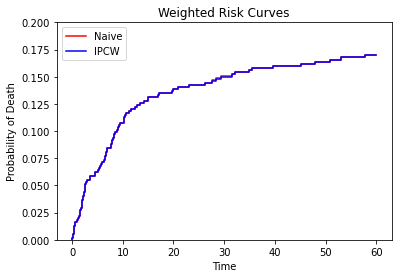

In [9]:
# Plotting risk functions
plt.step(km_n.event_table.index, 1 - km_n.survival_function_, where='post', c='r', label='Naive')
plt.step(km_c.event_table.index, 1 - km_c.survival_function_, where='post', c='b', label='IPCW')
plt.title('Weighted Risk Curves')
plt.xlabel('Time')
plt.ylabel('Probability of Death')
plt.legend()
plt.ylim([0,0.2])
plt.show()

While we see some slight differences, our two curves are largely overlapping. This suggests that there is not really a substantial extent of informative censoring by age and gender. 

### Bounds
For further sensitivity analysis, we can also generate the bounds. These bounds are extreme scenarios of censoring. Basically, the worst case. To create the bounds, we copy two data sets. One in which the censored individuals never have the event (the lower bound) and another in which the event happens right as the person is censored (the upper bound). 

Between these bounds are where all possible values for censored individuals must be between. They are useful for understanding the assumption of non-informative censoring and how strong that assumption is. Let's look at an example

In [10]:
# Restricting data to the last observation for each individual
dfr = df.loc[df['id'] != df['id'].shift(-1)].copy()

In [11]:
# Calculating Upper Bound
dfu = dfr.copy()
dfu.loc[dfu['drop'] == 1, 'dead'] = 1

km_u = KaplanMeierFitter()
km_u.fit(dfu['out'], event_observed=dfu['dead'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 547 total observations, 406 right-censored observations>

In [12]:
# Calculating Lower Bound
dfl = dfr.copy()
dfl.loc[dfl['drop'] == 1, 'out'] = 60

km_l = KaplanMeierFitter()
km_l.fit(dfl['out'], event_observed=dfl['dead'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 547 total observations, 455 right-censored observations>

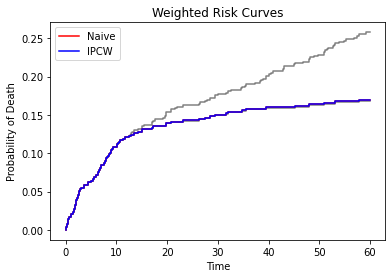

In [13]:
# Adding bounds to our previous plot
plt.step(km_u.event_table.index, 1 - km_u.survival_function_, where='post', c='gray', label=None)
plt.step(km_l.event_table.index, 1 - km_l.survival_function_, where='post', c='gray', label=None)

# previous plot
plt.step(km_n.event_table.index, 1 - km_n.survival_function_, where='post', c='r', label='Naive')
plt.step(km_c.event_table.index, 1 - km_c.survival_function_, where='post', c='b', label='IPCW')
plt.title('Weighted Risk Curves')
plt.xlabel('Time')
plt.ylabel('Probability of Death')
plt.legend()
plt.show()

As seen above, our estimate sits pretty close to one of the bounds (the lower bound). Additionally, the bounds don't spread out too far until censoring starts occurring.

## Time-Varying Covariates
Your colleague talked to some clinicians and they expressed concern that informative censoring may have been occurring by ART therapy and CD4 T-cell count. They are concerned since these are time-varying variables. Not a problem for IPCW via pooled logistic models. The time-varying variables are easily incorporate into this framework. In fact, we have mostly everything prepared. Let's re-estimate our IPCW but include ART, baseline CD4, and CD4 at that visit. Additionally, we will lag ART by one time unit and add that into our model as well. We will model CD4 with a quadratic and cubic terms

Below is code to do all of that

/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:312: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


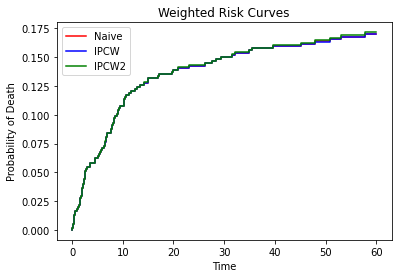

In [14]:
# Creating new variables
df['cd40_q'] = df['cd40']**2
df['cd40_c'] = df['cd40']**3
df['cd4_q'] = df['cd4']**2
df['cd4_c'] = df['cd4']**3

# Estimating new IPCW
ipcw = IPCW(df, idvar='id', time='enter', event='dead')
ipcw.regression_models('enter + enter_rs1 + enter_rs2 + male + age0 + age_rs1 + age_rs2 + ' + 
                       'art + cd40 + cd40_q + cd40_c + cd4 + cd4_q + cd4_c',
                      model_numerator='enter + enter_rs1 + enter_rs2',
                      print_results=False)
ipcw.fit()

df['cw_'] = ipcw.Weight

# Estimating Kaplan-Meier
km_c2 = KaplanMeierFitter()
km_c2.fit(df['out'], event_observed=df['dead'], entry=df['enter'],weights=df['cw_'])

# Plotting Results with others
plt.step(km_n.event_table.index, 1 - km_n.survival_function_, where='post', c='r', label='Naive')
plt.step(km_c.event_table.index, 1 - km_c.survival_function_, where='post', c='b', label='IPCW')
# adding new IPCW risk curve
plt.step(km_c2.event_table.index, 1 - km_c2.survival_function_, where='post', c='g', label='IPCW2')
plt.title('Weighted Risk Curves')
plt.xlabel('Time')
plt.ylabel('Probability of Death')
plt.legend()
plt.show()

We see a slight difference in our results when accounting for these additional variables. So, does this mean we can tell our colleague there is no informative censoring occurring? No. Rather it does not seem to be much informative censoring by *the selected variables, assuming no model misspecification*. We can never definitively claim no informative censoring (unless there is no censoring). 

What we can do is allow for some informative censoring to occur by measured variables. Essentially, we have weaked the assumption from no informative by *any variables* to no informative censoring *conditional on some set of variables*. This is progress. See the references for further details, explanations, and when bias can occur

## Conclusion
In this tutorial, I introduced inverse probability of censoring weights and how to calculate them using *zEpid*. While we focused on estimation of the overall risk function, these weights can be combined with IPTW to estimate marginal structural models for time-varying covariates. We will return to IPCW in the tutorials for causal inference with time-varying treatments

### References
Howe, CJ et al. (2016). Selection bias due to loss to follow up in cohort studies. *Epidemiology*, 27(1), 91.